# Introduction

It is well described by Mandelbrot that the motions of a financial asset market are much more akin to a fractal behavior. To study this, we will be applying turbulence statistics and quantum mechanics math to understand how the markets move.


# Methodology

The data will come from yfinance, which is a well-established Python API for the Yahoo finance database. For this study, we will be studying the following tickers due to their diversity in the market:

1) AAPL - Apple Inc, Tech Company
2) MKC - McCormick Inc, Food Company
3) X - US Steel, Heavy Industry Company


In [1]:
import yfinance as yf
import numpy as np
import scipy.optimize as sopt
from Project_daVinci_v0_0 import *
import matplotlib.pyplot as plt


In [2]:
##############################################################################################################################################################
#
# Calculation Parameters
#
##############################################################################################################################################################

tickers = [ 'AAPL' , 'MKC' , 'X' ]



In [3]:
###########################################################################################################################################################
#
# Plot Data
#
###########################################################################################################################################################

img_size = ( 10 , 7 )


## The Data Form

Let's pull some data to see what it looks like. We will do the S&P 500 Index first as an example, and we know it has reliable data for a long time.


In [4]:
tckr_data = ticker_datapull( "SPY" )


[*********************100%%**********************]  1 of 1 completed


The data is a dataframe, like from Pandas. Thus, it will have columns that allow us to view the data, and we can call columns as arrays of data.

The columns are Open, High, Low, Close, and Adjusted Close, which can all be used to pull data into a standard NumPy array.


In [5]:
tckr_data.columns


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
time_data = tckr_data['Close'].values


In [7]:
time_data


array([145.4375    , 139.75      , 140.        , ..., 476.51000977,
       476.69000244, 475.30999756])

In [8]:
timestamps = tckr_data.index


In [9]:
timestamps


DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=6037, freq=None)

We can also look at a Simple Moving Average of the Data


In [10]:
MA_period = 200
time_data_SMA = simpleMovingAverage( time_data , MA_period )

Thus, we can take the data and gather "velocity" data from the price, which takes the time gradient of the data to understand the price change as stochastic data.


In [11]:
U_SPY , U_norm_SPY , dl_loss = price_velocity( tickers[0] , movingaveragelength = MA_period )


[*********************100%%**********************]  1 of 1 completed


So let's plot our data for SPY.


In [12]:
dl_loss


199

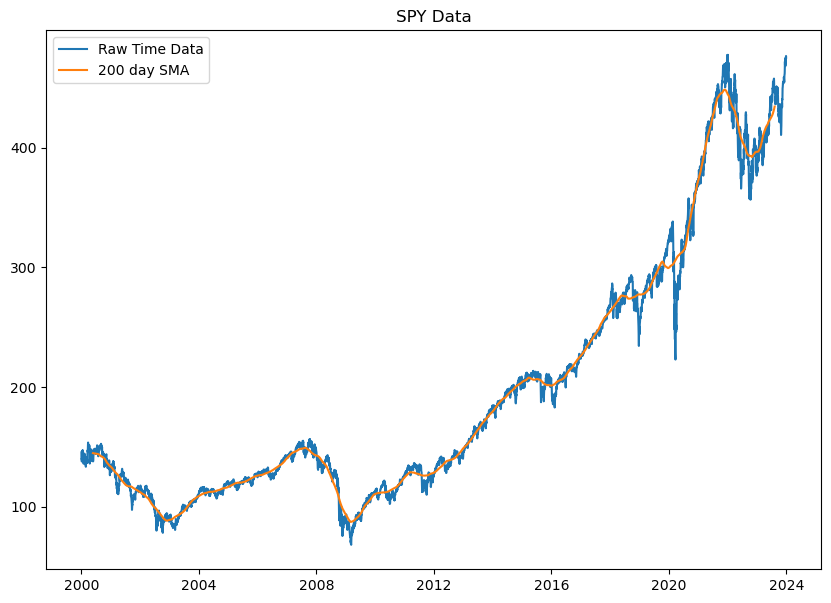

In [13]:
plt.figure( figsize = img_size )
x = np.arange( 1 , len( time_data )+1 )
x_SMA = np.arange( MA_period , len( time_data ) )
plt.plot( timestamps , time_data , label = 'Raw Time Data' )
plt.plot( timestamps[dl_loss//2:-dl_loss//2] , time_data_SMA[dl_loss:-dl_loss] , label = '{x} day SMA'.format(x=MA_period) )
plt.title( 'SPY Data' )
plt.legend( loc = 'best' )
plt.show()


Now, we need a way to understand how this data is changing in time.

One way to do this is to look at the autocorrelation of the data.


In [14]:
price_spectral_data = SpectralData( { 'Close' : tckr_data['Close'].values , 'Open' : tckr_data['Open'].values } , 
                                   fft_method = 'real' )


Using real FFT
Using real FFT


In [15]:
price_spectral_data.correlations()


C:\Users\mtthl\AppData\Local\Temp\ipykernel_14096\2405825029.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim((0,3e3))


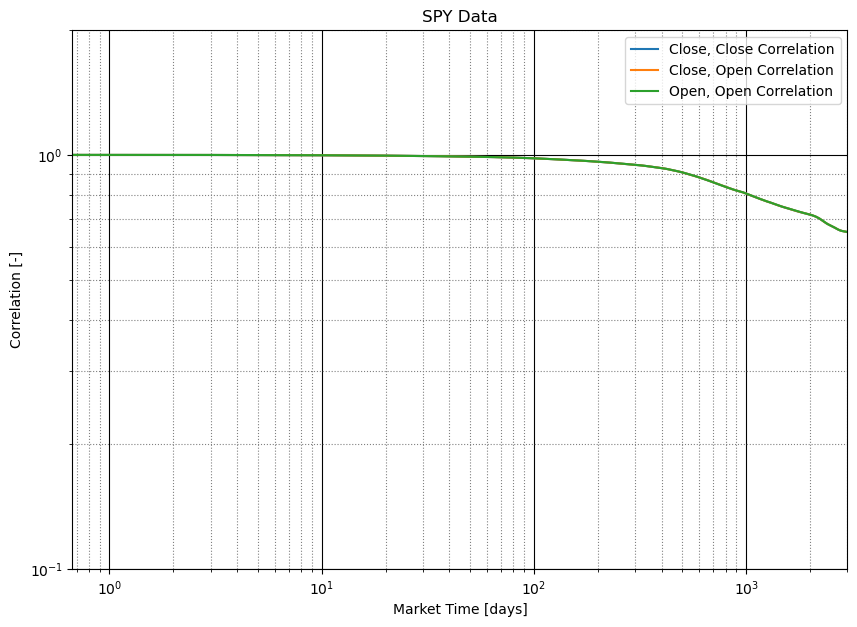

In [16]:
plt.figure( figsize = img_size )
x = np.arange( -len( time_data )//2+1 , len( time_data )//2 )
for i , v in enumerate( price_spectral_data.variables ):
    for j , w in enumerate( price_spectral_data.variables[i:]):
        plt.loglog( x , price_spectral_data.correlation[i,j,...] , label = v + ", " + w + " Correlation" )
plt.xlim((0,3e3))
plt.ylim((1e-1,2))
plt.grid( which = 'major' , color = 'k' , linestyle = '-' )
plt.grid( which = 'minor' , color = 'gray' , linestyle = ':' )
plt.title( 'SPY Data' )
plt.xlabel( 'Market Time [days]' )
plt.ylabel( 'Correlation [-]' )
plt.legend( loc = 'best' )
plt.show()


In [17]:
price_spectral_data.fullEnergy()


In [26]:
def f_exponential( x , a , b ):
    """
    This function provides an exponential function for SciPy to use to perform a curve fit.

    """

    return a * ( x ** b )


C:\Users\mtthl\AppData\Local\Temp\ipykernel_14096\704160043.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y = price_spectral_data.full_energy_spectra[i,j,...] / np.trapz( price_spectral_data.full_energy_spectra[i,j,...] , x = x )


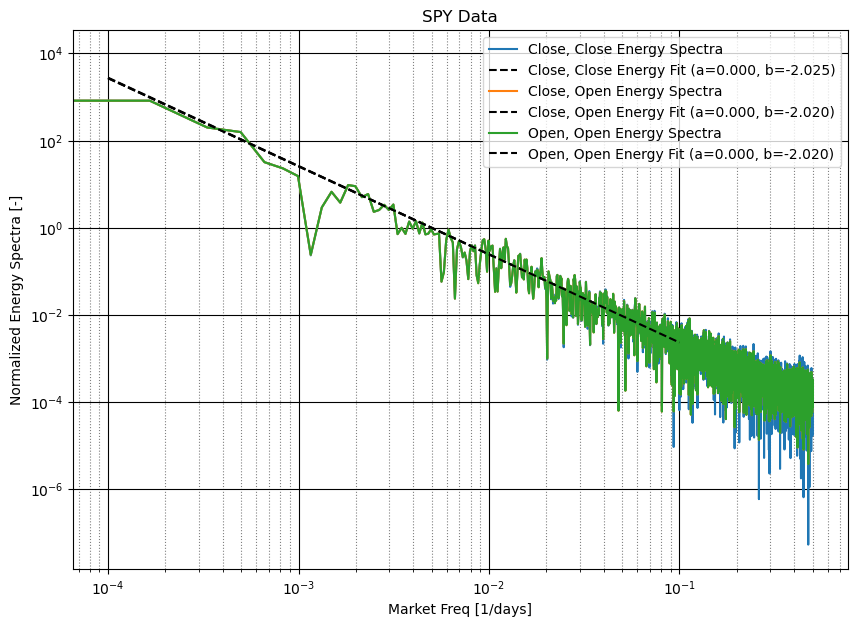

In [32]:
plt.figure( figsize = img_size )

a_s = [ 1 ] * 2
b_s = [ -10 ] * 2

for i , v in enumerate( price_spectral_data.variables ):
    for j , w in enumerate( price_spectral_data.variables[i:]):
        x = price_spectral_data.frequency_data[v]
        y = price_spectral_data.full_energy_spectra[i,j,...] / np.trapz( price_spectral_data.full_energy_spectra[i,j,...] , x = x )
        plt.loglog( x , y , label = v + ", " + w + " Energy Spectra" )

        popt , pcov = sopt.curve_fit( f_exponential , x[100:] , y[100:] )
        x_fit = np.logspace( -4 , -1 , num = 20 )
        y_fit = f_exponential( x_fit , popt[0] , popt[1] )
        plt.loglog( x_fit , y_fit , '--k' , label = v + ", " + w + " Energy Fit (a={x:.3f}, b={y:.3f})".format(x=popt[0],y=popt[1]))

#plt.xlim((0,3e3))
#plt.ylim((1e-1,2))
plt.grid( which = 'major' , color = 'k' , linestyle = '-' )
plt.grid( which = 'minor' , color = 'gray' , linestyle = ':' )
plt.title( 'SPY Data' )
plt.xlabel( 'Market Freq [1/days]' )
plt.ylabel( 'Normalized Energy Spectra [-]' )
plt.legend( loc = 'best' )
plt.show()


Now, the next step is to look at the same data, but in terms of the trades made rather than the market time.


In [33]:
volume_data = tckr_data['Volume'].values


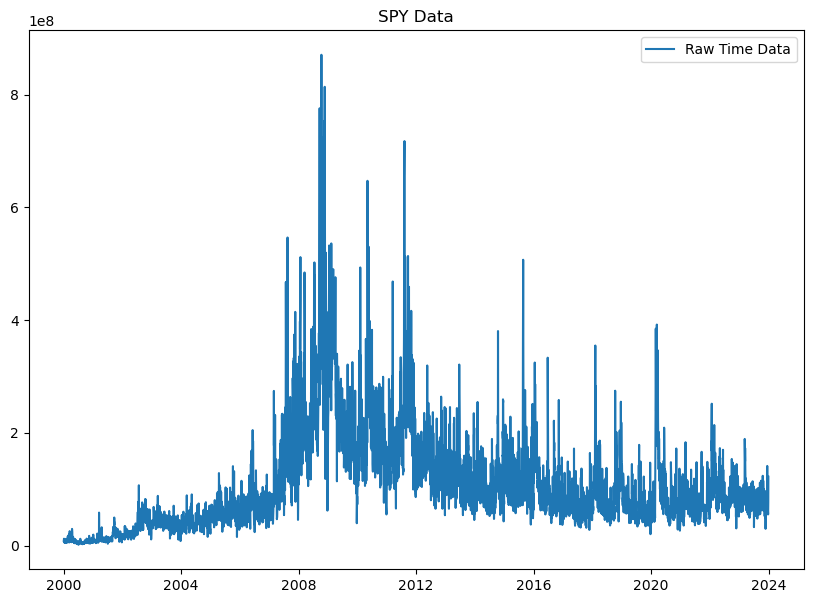

In [34]:
plt.figure( figsize = img_size )
x = np.arange( 1 , len( time_data )+1 )
plt.plot( timestamps , volume_data , label = 'Raw Time Data' )
plt.title( 'SPY Data' )
plt.legend( loc = 'best' )
plt.show()
